<a href="https://colab.research.google.com/github/sragnetti99/BookRecommender/blob/main/BookRecommender_SaraRagnetti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Book Recommender

Scopo del progetto è quello di realizzare un semplice Book recommender sulla base dei dati raccolti in tre dataset diversi:

1.   BX-Books contiene informazioni sui libri;
2.   BX-Users contiene informazioni sugli utenti;
3.   BX-Book-Ratings contiene informazioni relative ai voti dati dagli utenti sui libri.

Verranno presentati diversi modelli di recommender.

Progetto di Applicazioni di Data Intensive a.a. 2021/2022

**Realizzato da**: Sara Ragnetti

sara.ragnetti@studio.unibo.it

# Caricamento Librerie

Prima di iniziare, è bene importare tutte le librerie necessarie per effettuare operazioni sui dati.

*   csv: libreria per leggere e scrivere dati da forma tabulare in file CSV; 
*   pandas: libreria che fornisce strutture e strumenti per l'analisi di dati in linguaggio Python;
*   numpy: lavorare con vettori e matrici in maniera più efficiente e veloce;
* seaborn: libreria per la creazione di grafici statistici;
* pyplot:  libreria per la creazione di grafici per il linguaggio di programmazione Python e la libreria matematica NumPy.


In [ ]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
global k #,metric
k=4
#metric='cosine'

I dataset utilizzati in questa sede sono stati reperiti dal seguente indirizzo: http://www2.informatik.uni-freiburg.de/~cziegler/BX/

Per poter eseguire tutte le seguenti istruzioni bisognerà importare i file .csv nella cartella "sample_data".

Prima di costruire il modello di Machine Learning per un book recommender, occorre comprendere ed analizzare i dati che saranno utilizzati nello svolgimento del progetto.

In [ ]:
books = pd.read_csv('sample_data/BX-Books.csv', sep=";", error_bad_lines=False, encoding="latin-1")
books.columns = ["ISBN", "bookTitle", "bookAuthor", "yearOfPubblication", "publisher", "imageUrlS", "imageUrlM", "imageUrlL"]

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 

In [ ]:
books.shape

(271360, 8)

In [ ]:
users = pd.read_csv('sample_data/BX-Users.csv', sep=";", encoding="latin-1") # error_bad_lines=False
users.columns = ["userId", "Location", "Age"]

In [ ]:
users.shape

(278858, 3)

In [ ]:
ratings = pd.read_csv('sample_data/BX-Book-Ratings.csv', sep=";", encoding="latin-1",) # error_bad_lines=False
ratings.columns = ["userId", "ISBN", "bookRating"]

In [ ]:
ratings.shape

(1149780, 3)

## Books

Esploriamo ora ciascuno dei tre dataset importati, iniziando da quello dei libri. 

In [ ]:
books.head()

,ISBN,bookTitle,bookAuthor,yearOfPubblication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


### Significati delle colonne

- `ISBN`: codice univoco del libro
- `bookTitle`: titolo del libro
- `bookAuthor`: autore del libro
- `yearOfPublication`: anno di pubblicazione
- `publisher`: casa editrice
- `imageUrlS`: immagine della copertina del libro in formato small (S)
- `imageUrlM`: immagine della copertina del libro in formato medium (M)
- `imageUrlL`: immagine della copertina del libro in formato large (L)

Le colonne relative alle immagini non sono necessarie per l'analisi, quindi sarebbe opportuno rimuoverle.

In [ ]:
books.drop(['imageUrlS', 'imageUrlM', 'imageUrlL'], axis=1, inplace=True)

In [ ]:
books.head()

,ISBN,bookTitle,bookAuthor,yearOfPubblication,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


Sistemiamo la tabella in modo che sia visibile il testo completo di ogni sua colonna.

In [ ]:
pd.set_option('display.max_colwidth', None)

Effettuiamo dei controlli su alcuni attributi. Iniziamo visualizzando i tipi degli elementi lungo le colonne.

In [ ]:
books.dtypes

ISBN                  object
bookTitle             object
bookAuthor            object
yearOfPubblication    object
publisher             object
dtype: object

**yearOfPubblication**

Prima controlliamo i valori della colonna yearOfPubblication e osserviamo che è presente uno 0. 
Probabilmente si tratta di un errore del dataset, quindi andiamo a sostituire quel valore con la media degli anni di pubblicazione di tutti gli altri libri.

Sembrerebbe inoltre ragionevole convertire il tipo di tutti valori della colonna yearOfPubblication in int32.

In [ ]:
books.yearOfPubblication.unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

Risulta inotre evidente che due publisher siano stati erroneamente inseriti come yearOfPublication. Dobbiamo rimuoverli.

In [ ]:
books.loc[books.yearOfPubblication == 'DK Publishing Inc', :]

,ISBN,bookTitle,bookAuthor,yearOfPubblication,publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\"";Michael Teitelbaum""",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)\"";James Buckley""",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.01.THUMBZZZ.jpg


Adesso sistemiamo manualmente i valori sballati, in particolare effettiamo lo switch tra il valore di yearOfPubblication e quello di publisher.

In [ ]:
books.loc[books.ISBN == '078946697X', 'yearOfPubblication'] = 2000
books.loc[books.ISBN == '078946697X', 'bookAuthor'] = "Michael Teitelbaum"
books.loc[books.ISBN == '078946697X', 'bookTitle'] = 'DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)'
books.loc[books.ISBN == '078946697X', 'publisher'] = 'DK Publishing Inc'

books.loc[books.ISBN == '0789466953', 'yearOfPubblication'] = 2000
books.loc[books.ISBN == '0789466953', 'bookAuthor'] = "James Buckley"
books.loc[books.ISBN == '0789466953', 'bookTitle'] = 'DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)'
books.loc[books.ISBN == '0789466953', 'publisher'] = 'DK Publishing Inc'

In [ ]:
books.loc[books.yearOfPubblication == 'Gallimard', :]

,ISBN,bookTitle,bookAuthor,yearOfPubblication,publisher
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-Marie Gustave Le ClÃ?Â©zio""",2003,Gallimard,http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg


In [ ]:
books.loc[books.ISBN == '2070426769', 'yearOfPubblication'] = 2003
books.loc[books.ISBN == '2070426769', 'bookAuthor'] = "Jean-Marie Gustave"
books.loc[books.ISBN == '2070426769', 'bookTitle'] = 'Peuple du ciel, suivi de Les Bergers'
books.loc[books.ISBN == '2070426769', 'publisher'] = 'Gallimard'

In [ ]:
books.yearOfPubblication = pd.to_numeric(books.yearOfPubblication, errors = 'coerce')
sorted(books['yearOfPubblication'].unique())

[0,
 1376,
 1378,
 1806,
 1897,
 1900,
 1901,
 1902,
 1904,
 1906,
 1908,
 1909,
 1910,
 1911,
 1914,
 1917,
 1919,
 1920,
 1921,
 1922,
 1923,
 1924,
 1925,
 1926,
 1927,
 1928,
 1929,
 1930,
 1931,
 1932,
 1933,
 1934,
 1935,
 1936,
 1937,
 1938,
 1939,
 1940,
 1941,
 1942,
 1943,
 1944,
 1945,
 1946,
 1947,
 1948,
 1949,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2008,
 2010,
 2011,
 2012,
 2020,
 2021,
 2024,
 2026,
 2030,
 2037,
 2038,
 2050]

È possibile vedere che yearOfPublication è di tipo int e ha valori compresi tra 0 e 2050. Considerando che questo set di dati è stato creato nel 2004, si presume che tutti gli anni successivi al 2006 non siano validi. Si mantiene comunque un margine di due anni nell'eventualità che il set di dati possa essere stato aggiornato. 
Tutti i valori non validi (inclusi gli 0), li converto in NaN, quindi li sostituirò con i valori medi degli anni rimanenti.

In [ ]:
books.loc[(books.yearOfPubblication > 2006) | (books.yearOfPubblication == 0), 'yearOfPubblication'] = np.NAN
books.yearOfPubblication.fillna(round(books.yearOfPubblication.mean()), inplace=True)

In [ ]:
books.yearOfPubblication = books.yearOfPubblication.astype(np.int32)

In [ ]:
books.yearOfPubblication.unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 1968, 1961, 1958, 1974, 1976,
       1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960, 1966,
       1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954, 1950,
       1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 1925, 1948,
       1943, 1947, 1945, 1923, 1939, 1926, 1938, 1911, 1904, 1949, 1932,
       1928, 1929, 1927, 1931, 1914, 1934, 1910, 1933, 1902, 1924, 1921,
       1900, 1944, 1917, 1901, 1908, 1906, 1935, 1806, 2006, 1909, 1378,
       1919, 1922, 1897, 1376], dtype=int32)

**publisher**

Anche nella colonna publisher ci sono dei valori sballati.
In questo caso, non potendo fare dei calcoli con questi dati, rimpiazziamo i vaori nulli con 'other'.

In [ ]:
books.loc[books.publisher.isnull(), :]

,ISBN,bookTitle,bookAuthor,yearOfPubblication,publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN


In [ ]:
books.loc[(books.ISBN == '193169656X'), 'publisher'] = 'other'
books.loc[(books.ISBN == '1931696993'), 'publisher'] = 'other'

## Users

In [ ]:
users.head()

,userId,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


### Significati delle colonne

- `userId`: codice univoco dell'utente
- `age`: età dell'utente
- `location`: città, stato e paese di residenza dell'utente

Effettuiamo alcuni controlli preliminari sul dataset relativo agli utenti.

In [ ]:
users.shape

(278858, 3)

In [ ]:
users.userId.nunique()

278858

In [ ]:
users.head()

,userId,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [ ]:
users.dtypes

userId        int64
Location     object
Age         float64
dtype: object

**Age**

La colonna degli ID sembra essere corretta poichè il numero di ID univoci corrisponde al totale degli utenti, ma lo stesso non si può dire di age. Qui compaiono dei NaN e alcuni valori o troppo alti (> 90) o troppo bassi (< 5). 
Inizialmente trasformiamo queste ultime età in NaN, e poi sostituiamo tutti i NaN con un valore pari alla medià delle età di tutti gli utenti.

Controlliamo la distribuzione dell'età: gli utenti più 'attivi' (che hanno dato più voti) hanno un'età compresa tra i 20 e i 30 anni.

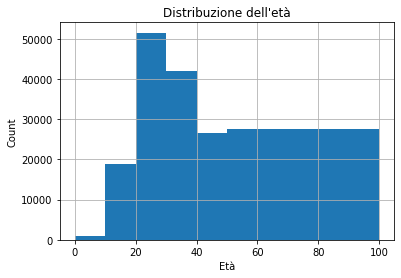

In [ ]:
users.Age.hist(bins=[0, 10, 20, 30, 40, 50, 100])
plt.title('Distribuzione dell\'età')
plt.xlabel('Età')
plt.ylabel('Count')
plt.savefig('foto2.png', bbox_inches='tight')
plt.show()

In [ ]:
users.Age.unique()

array([ nan,  18.,  17.,  61.,  26.,  14.,  25.,  19.,  46.,  55.,  32.,
        24.,  20.,  34.,  23.,  51.,  31.,  21.,  44.,  30.,  57.,  43.,
        37.,  41.,  54.,  42.,  50.,  39.,  53.,  47.,  36.,  28.,  35.,
        13.,  58.,  49.,  38.,  45.,  62.,  63.,  27.,  33.,  29.,  66.,
        40.,  15.,  60.,   0.,  79.,  22.,  16.,  65.,  59.,  48.,  72.,
        56.,  67.,   1.,  80.,  52.,  69.,  71.,  73.,  78.,   9.,  64.,
       103., 104.,  12.,  74.,  75., 231.,   3.,  76.,  83.,  68., 119.,
        11.,  77.,   2.,  70.,  93.,   8.,   7.,   4.,  81., 114., 230.,
       239.,  10.,   5., 148., 151.,   6., 101., 201.,  96.,  84.,  82.,
        90., 123., 244., 133.,  91., 128.,  94.,  85., 141., 110.,  97.,
       219.,  86., 124.,  92., 175., 172., 209., 212., 237.,  87., 162.,
       100., 156., 136.,  95.,  89., 106.,  99., 108., 210.,  88., 199.,
       147., 168., 132., 159., 186., 152., 102., 116., 200., 115., 226.,
       137., 207., 229., 138., 109., 105., 228., 18

In [ ]:
users.loc[(users.Age < 5) | (users.Age > 90), 'Age'] = np.nan

In [ ]:
users.Age = users.Age.fillna(users.Age.mean())
users.Age = users.Age.astype(np.int32)
users.Age.unique()

array([34, 18, 17, 61, 26, 14, 25, 19, 46, 55, 32, 24, 20, 23, 51, 31, 21,
       44, 30, 57, 43, 37, 41, 54, 42, 50, 39, 53, 47, 36, 28, 35, 13, 58,
       49, 38, 45, 62, 63, 27, 33, 29, 66, 40, 15, 60, 79, 22, 16, 65, 59,
       48, 72, 56, 67, 80, 52, 69, 71, 73, 78,  9, 64, 12, 74, 75, 76, 83,
       68, 11, 77, 70,  8,  7, 81, 10,  5,  6, 84, 82, 90, 85, 86, 87, 89,
       88], dtype=int32)

**Location**

Per fare un po' di chiarezza, divdiamo la colonna Location in 3 colonne:
* City;
* State;
* Country.

e consideriamo, da ora in poi, solo Country.

In [ ]:
users[['City', 'State', 'Country']] = users['Location'].str.split(',', 2, expand=True)
users

,userId,Location,Age,City,State,Country
0,1,"nyc, new york, usa",34,nyc,new york,usa
1,2,"stockton, california, usa",18,stockton,california,usa
2,3,"moscow, yukon territory, russia",34,moscow,yukon territory,russia
3,4,"porto, v.n.gaia, portugal",17,porto,v.n.gaia,portugal
4,5,"farnborough, hants, united kingdom",34,farnborough,hants,united kingdom
...,...,...,...,...,...,...
278853,278854,"portland, oregon, usa",34,portland,oregon,usa
278854,278855,"tacoma, washington, united kingdom",50,tacoma,washington,united kingdom
278855,278856,"brampton, ontario, canada",34,brampton,ontario,canada
278856,278857,"knoxville, tennessee, usa",34,knoxville,tennessee,usa


In [ ]:
users.drop(['Location', 'City', 'State'], axis=1, inplace=True)
users

,userId,Age,Country
0,1,34,usa
1,2,18,usa
2,3,34,russia
3,4,17,portugal
4,5,34,united kingdom
...,...,...,...
278853,278854,34,usa
278854,278855,50,united kingdom
278855,278856,34,canada
278856,278857,34,usa


In [ ]:
users.rename(columns = {'Country':'Location'}, inplace = True)
users

,userId,Age,Location
0,1,34,usa
1,2,18,usa
2,3,34,russia
3,4,17,portugal
4,5,34,united kingdom
...,...,...,...
278853,278854,34,usa
278854,278855,50,united kingdom
278855,278856,34,canada
278856,278857,34,usa


## Ratings

In [ ]:
ratings.head()

,userId,ISBN,bookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


### Significati delle colonne

- `userId`: codice univoco dell'utente
- `ISBN`: codice univoco del libro
- `bookRating`: voto dato dall'utente x ad un libro y

Analizzando il dataset dei ratings ci accorgiamo che la matrice user-books ratings ha dei valori sparsi, in quanto il numero di ratings è inferiore alla dimensione della matrice books x users.

In [ ]:
ratings.shape

(1149780, 3)

In [ ]:
n_users = users.shape[0]
n_books = books.shape[0]

n_users * n_books 

75670906880

# Distribuzione dei ratings

I ratings hanno una distribuzione tutt'altro che comparabile. Infatti, la maggior parte dei punteggi ha valore 0, che indica assenza di voto.

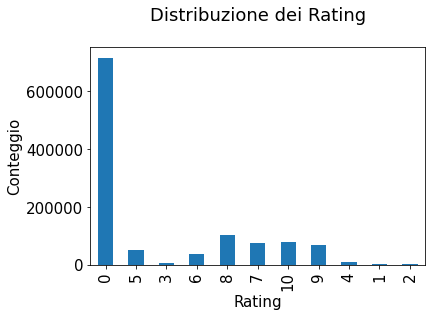

In [ ]:
from pyparsing.helpers import counted_array
plt.rc("font", size=15)
ratings.bookRating.value_counts(sort=False).plot(kind='bar')
plt.title('Distribuzione dei Rating\n')
plt.xlabel('Rating')
plt.ylabel('Conteggio')
plt.savefig('foto1.png', bbox_inches='tight')
plt.show()

Diamo una misura della sparsità dei dati.

In [ ]:
sparsity = 1.0-len(ratings)/float(n_users*n_books)

print("La sparsità dei dati è pari al " + str(sparsity*100) + " %")

La sparsità dei dati è pari al 99.99848055210727 %


Verifichiamo che i ratings siano relativi a dei libri presenti nel dataset books e che siano effettuati da utenti presenti in users.

In [ ]:
new_ratings = ratings[ratings.ISBN.isin(books.ISBN)]
new_ratings = new_ratings[new_ratings.userId.isin(users.userId)]

In [ ]:
ratings.shape

(1149780, 3)

Il numero di ratings è diminuito, quindi alcuni voti erano stati erroneamente inseriti nel dataset.

In [ ]:
new_ratings.shape

(1031136, 3)

Occorre fare una distinzione, separando le valutazioni **esplicite**, rappresentate dai voti compresi tra 1–10 dalle valutazioni **implicite**, con valori pari a 0. 
Utilizzeremo solo valutazioni esplicite per creare il nostro sistema di book recommendation. 
Allo stesso modo, bisogna separare gli utenti che hanno dato valutazioni esplicite e quelli che hanno dato valutazioni implicite.

In [ ]:
ratings.bookRating.unique()

array([ 0,  5,  3,  6,  8,  7, 10,  9,  4,  1,  2])

In [ ]:
explicit_ratings = new_ratings[new_ratings.bookRating  != 0]
implicit_ratings = new_ratings[new_ratings.bookRating  == 0]

In [ ]:
users_explicit_ratings = users[users.userId.isin(explicit_ratings.userId)]
users_implicit_ratings = users[users.userId.isin(implicit_ratings.userId)]

Visualizziamo graficamente il conteggio di ciascun rating attraverso un countplot e notiamo che il voto 8 è quello dato più volte.

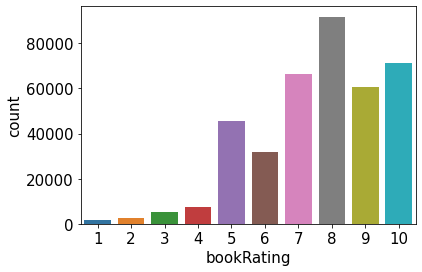

In [ ]:
sns.countplot(data=explicit_ratings, x='bookRating')
plt.show()

# Sistema di recommendation basato sulla popolarità

Si può creare un semplice sistema di recommedation basato sulla popolarità in base al conteggio delle valutazioni degli utenti per i diversi libri. 


Per assicurarci di ottenere delle statistiche significative, per questo tipo di analisi riduciamo le dimensioni del dataset escludendo gli utenti che hanno dato meno di 100 voti e i libri che hanno ricevuto meno di 100 voti.

In [ ]:
counts1 = explicit_ratings['userId'].value_counts()
explicit_ratings = explicit_ratings[explicit_ratings['userId'].isin(counts1[counts1 >= 100].index)]
counts = explicit_ratings['bookRating'].value_counts()
explicit_ratings = explicit_ratings[explicit_ratings['bookRating'].isin(counts[counts >= 100].index)]

In [ ]:
# calcolo la somma dei ratings di ogni libro
ratings_count = pd.DataFrame(explicit_ratings.groupby(['ISBN'])['bookRating'].sum())
# cerco i 10 libri più votati ordinando per bookRating decrescente
top10 = ratings_count.sort_values('bookRating', ascending=False).head(10)

print("I libri seguenti sono quelli più consigliati:")

# unisco i 10 libri più votati alle informazioni specifiche relative ad essi
top10.merge(books, left_index = True, right_on = 'ISBN')

I libri seguenti sono quelli più consigliati:


,bookRating,ISBN,bookTitle,bookAuthor,yearOfPubblication,publisher
408,595,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown"
2143,411,059035342X,Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),J. K. Rowling,1999,Arthur A. Levine Books
5506,409,043935806X,Harry Potter and the Order of the Phoenix (Book 5),J. K. Rowling,2003,Scholastic
748,400,0385504209,The Da Vinci Code,Dan Brown,2003,Doubleday
522,375,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA
37,358,0446310786,To Kill a Mockingbird,Harper Lee,1988,Little Brown &amp; Company
5431,331,0439139597,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,2000,Scholastic
1195,320,0345370775,Jurassic Park,Michael Crichton,1999,Ballantine Books
5432,314,0439064864,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,1999,Scholastic
3839,300,0439136350,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,1999,Scholastic


Il recommender che abbiamo creato suggerisce che i romanzi sono molto popolari, in particolare quelli di J.K.Rowling; e anche che se a qualcuno, per esempio, è piaciuto "The red tent", probabilmente apprezzerà anche "The lovely bones: a novel".

Chiaramente un modello di questo tipo non è molto affidabile dato che non si basa affatto sulle similarità tra utenti o prodotti.

# Sistema di recommendation basato sulla correlazione

Usiamo il coefficiente di correlazione di Pearsons (R) per misurare la correlazione lineare tra due variabili, che nel nostro caso costituiscono le valutazioni di due libri.

Innanzitutto, dobbiamo scoprire la valutazione media e il numero di valutazioni (ratings) ricevute da ciascun libro.

In [ ]:
# calcolo la media dei ratings di ogni libro
average_rating = pd.DataFrame(ratings.groupby('ISBN')['bookRating'].mean())

# aggiungo la colonna con il conteggio dei ratings che ha ricevuto ogni libro
average_rating['ratingCount'] = pd.DataFrame(ratings.groupby('ISBN')['bookRating'].count())

print("I libri seguenti sono quelli più consigliati:")

# ordino i risultati per numero di voti decrescente (ascending = false)
average_rating.sort_values('ratingCount', ascending = False).merge(books, left_index = True, right_on = 'ISBN').head()


I libri seguenti sono quelli più consigliati:


,bookRating,ratingCount,ISBN,bookTitle,bookAuthor,yearOfPubblication,publisher
26,1.019584,2502,0971880107,Wild Animus,Rich Shapero,2004,Too Far
408,4.468726,1295,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown"
748,4.652322,883,0385504209,The Da Vinci Code,Dan Brown,2003,Doubleday
1105,3.448087,732,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial
522,4.334716,723,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA


**Osservazioni**

Da questo dataset risulta evidente che il libro che ha ricevuto più votazioni (2502 per l'esattezza) ha realtà ricevuto un punteggio totale troppo basso (1.019584).

Escludiamo gli utenti che hanno dato meno di 200 voti e i libri che hanno ricevuto meno di 100 voti.

In [ ]:
counts1 = ratings['userId'].value_counts()
ratings = ratings[ratings['userId'].isin(counts1[counts1 >= 200].index)]
counts = ratings['bookRating'].value_counts()
ratings = ratings[ratings['bookRating'].isin(counts[counts >= 100].index)]

Convertiamo la tabella ratings in una matrice 2D. QUesta matrice sarà sparsa perché non tutti gli utenti hanno valutato tutti i libri.

In [ ]:
ratings_matrix = ratings.pivot(index='userId', columns='ISBN').bookRating
userId = ratings_matrix.index
ISBN = ratings_matrix.columns

print(ratings_matrix.shape)
ratings_matrix.head()

(905, 207699)


ISBN,0330299891,0375404120,0586045007,9022906116,9032803328,9044922564,9044922572,9044922718,9044923161,904492401X,...,UNGRANDHOMMED,X000000000,"YOUTELLEM,AND",ZR903CX0003,"\0432534220\""""","\2842053052\""""",b00005wz75,cn108465,cn113107,Ô½crosoft
userId,,,,,,,,,,,,,,,,,,,,,
254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Scopriamo quali libri sono correlati al secondo più votato "The lovely bones: a novel".

In [ ]:
wild_ratings = ratings_matrix['0316666343']
similar_to_wild = ratings_matrix.corrwith(wild_ratings)
corr_wild = pd.DataFrame(similar_to_wild, columns=['pearsonR'])
corr_wild.dropna(inplace=True)
corr_summary = corr_wild.join(average_rating['ratingCount'])
corr_summary[corr_summary['ratingCount']>= 300].sort_values('pearsonR', ascending=False).head(10)

/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,pearsonR,ratingCount
ISBN,,
0316666343,1.000000,1295
0312291639,0.471872,354
0316601950,0.434248,568
0446610038,0.429712,391
0446672211,0.421478,585
0385265700,0.351635,319
0345342968,0.316922,321
0060930535,0.309860,494
0375707972,0.308145,354


Otteniamo i titoli dei libri a partire dagli ISBN del precedente risultato, in modo da avere una tabella leggibile.

In [ ]:
books_corr_to_bones = pd.DataFrame(['0312291639', '0316601950', '0446610038', '0446672211', '0385265700', '0345342968', '0060930535', '0375707972', '0671021001'], 
                                  index=np.arange(9), columns=['ISBN'])
corr_books = pd.merge(books_corr_to_bones, books, on='ISBN')
corr_books

,ISBN,bookTitle,bookAuthor,yearOfPubblication,publisher
0,0312291639,The Nanny Diaries: A Novel,Emma McLaughlin,2003,St. Martin's Griffin
1,0316601950,The Pilot's Wife : A Novel,Anita Shreve,1999,Back Bay Books
2,0446610038,1st to Die: A Novel,James Patterson,2002,Warner Vision
3,0446672211,Where the Heart Is (Oprah's Book Club (Paperback)),Billie Letts,1998,Warner Books
4,0385265700,The Book of Ruth (Oprah's Book Club (Paperback)),Jane Hamilton,1990,Anchor
5,0345342968,Fahrenheit 451,RAY BRADBURY,1987,Del Rey
6,0060930535,The Poisonwood Bible: A Novel,Barbara Kingsolver,1999,Perennial
7,0375707972,The Reader,Bernhard Schlink,1999,Vintage Books USA
8,0671021001,She's Come Undone (Oprah's Book Club),Wally Lamb,1998,Pocket


# Recommendation con Surprise

- _Surprise_ è una libreria Python per la creazione e la validazione di modelli di recommendation
  - definisce strutture per rappresentare i dati su cui addestrare i modelli
  - permette di caricare dati da diverse fonti o di utilizzare dataset d'esempio
  - implementa diverse tecniche basate su similarità, scomposizione di matrici, ecc...
  - fornisce funzionalità per validare i modelli calcolando comuni metriche di accuratezza come il RMSE

In [ ]:
pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 771 kB 5.2 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp38-cp38-linux_x86_64.whl size=2626466 sha256=8fce886b65bad501c7ea0b327463c04eff5c8714c45d56ba5ddf9e739b9718a7
  Stored in directory: /root/.cache/pip/wheels/af/db/86/2c18183a80ba05da35bf0fb7417aac5cddbd93bcb1b92fd3ea
Successfully built scikit-surprise


In [ ]:
import surprise

In [ ]:
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split

In [ ]:
user = pd.read_csv('sample_data/BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
user.columns = ['userID', 'Location', 'Age']
rating = pd.read_csv('sample_data/BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
rating.columns = ['userID', 'ISBN', 'bookRating']

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


Uniamo i dataset user e ratings per affrontare questo tipo di analisi fatta con Surprise.

In [ ]:
df = pd.merge(user, rating, on='userID', how='inner')
df.drop(['Location', 'Age'], axis=1, inplace=True)
df.head()

,userID,ISBN,bookRating
0,2,0195153448,0
1,7,034542252,0
2,8,0002005018,5
3,8,0060973129,0
4,8,0374157065,0


In [ ]:
df.shape

(1149780, 3)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   userID      1149780 non-null  int64 
 1   ISBN        1149780 non-null  object
 2   bookRating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 35.1+ MB


##Distribuzione rating per libro

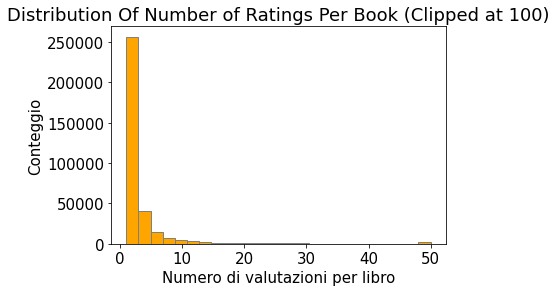

In [ ]:
figura, grafico= plt.subplots()
data = df.groupby('ISBN')['bookRating'].count().clip(upper=50) # Number of ratings per book
grafico.hist(x = data, 
             bins = 25,
             ec = "grey",
             fc = "orange")

plt.xlabel('Numero di valutazioni per libro')
plt.ylabel('Conteggio')
plt.title('Distribution Of Number of Ratings Per Book (Clipped at 100)')
plt.show()

In [ ]:
df.groupby('ISBN')['bookRating'].count().reset_index().sort_values('bookRating', ascending=False).head(10)

,ISBN,bookRating
247408,0971880107,2502
47371,0316666343,1295
83359,0385504209,883
9637,0060928336,732
41007,0312195516,723
101670,044023722X,647
166705,0679781587,639
28153,0142001740,615
166434,067976402X,614
153620,0671027360,586


In [ ]:
df.groupby('ISBN')['bookRating'].count().reset_index().sort_values('bookRating', ascending=False).tail(10)

,ISBN,bookRating
200155,0801062918,1
200156,0801063248,1
200157,080106340X,1
200158,080106385X,1
200159,0801064031,1
200161,0801064090,1
200162,0801064252,1
200163,0801064279,1
200164,0801064333,1
340555,Ô½crosoft,1


Raggruppando i libri per numero di valutazioni ottenute osserviamo che alcuni libri hanno ricevuto troppi pochi voti; e quello che ne ha ricevute di più ne conta ben 2502.

##Distribuzione rating per utente

In [ ]:
df.groupby('userID')['bookRating'].count().reset_index().sort_values('bookRating', ascending=False).head(10)

,userID,bookRating
4213,11676,13602
74815,198711,7550
58113,153662,6109
37356,98391,5891
13576,35859,5850
80185,212898,4785
105111,278418,4533
28884,76352,3367
42037,110973,3100
88584,235105,3067


In [ ]:
df.groupby('userID')['bookRating'].count().reset_index().sort_values('bookRating', ascending=False).tail(10)

,userID,bookRating
44886,118589,1
44881,118582,1
44874,118562,1
44880,118581,1
44879,118580,1
44878,118579,1
44877,118576,1
44876,118574,1
44875,118563,1
52641,139146,1


Da questi dati emerge che alcuni utenti hanno dato meno di 5 voti e il più attivo ne ha dati 13602.

Per ridurre la dimensione del data frame, scartiamo i libri che sono stati votati da meno utenti e gli utenti meno attivi.

In [ ]:
min_book_ratings = 50
filter_books = df['ISBN'].value_counts() > min_book_ratings
filter_books = filter_books[filter_books].index.tolist()

min_user_ratings = 50
filter_users = df['userID'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_new = df[(df['ISBN'].isin(filter_books)) & (df['userID'].isin(filter_users))]
print('Dimensione data frame originale:\t{}'.format(df.shape))
print('Dimensione nuovo data frame:\t{}'.format(df_new.shape))

Dimensione data frame originale:	(1149780, 3)
Dimensione nuovo data frame:	(140516, 3)


Per convertire un dataframe pandas in dataset utilizziamo il metodo load_from_df().
Poi avremo bisogno anche di un oggetto Reader in cui specificheremo una rating_scale.
Il dataframe deve avere tre colonne corrispondenti all'id dell'utente, l'id del libro e la valutazione, in quest'ordine.

In [ ]:
reader = Reader(rating_scale=(0, 9))
data = Dataset.load_from_df(df_new[['userID', 'ISBN', 'bookRating']], reader)

Con la libreria Surprise, faremo una prova delle prestazioni (benchmark) dei seguenti algoritmi:

**NormalPredictor**

*   prevede una valutazione casuale basata sulla distribuzione del training set, che si presume sia normale. 

**BaselineOnly**

*  prevede la stima di base per un determinato utente ed elemento.

**KNNBasic**
*  algoritmo di collaborative filtering.

**KNNWithMeans**
*   algoritmo di collaborative filtering, che tiene conto delle valutazioni medie di ciascun utente.

**KNNWithZScore**
*   algoritmo di collaborative filtering, che tiene conto della normalizzazione del punteggio z di ogni utente.

**KNNBaseline**
* algoritmo di collaborative filtering, che tiene conto di una valutazione di base.

**SVD**
* l'equivalente della Probabilistic Matrix Factorization.

**SVDpp**
* un'estensione di SVD che tiene conto delle valutazioni implicite.

**NMF**
* algoritmo di collaborative filtering, basato sulla fattorizzazione della matrice non negativa. È molto simile a SVD.

**Slope One**
* una semplice implementazione dell'algoritmo SlopeOne. 

**Co-clustering**
* algoritmo di collaborative filtering, basato sul co-clustering.

In [ ]:
benchmark = []
# Iteriamo su tutti gli algoritmi
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # effettuiamo la cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # associamo i risultati ai nomi degli algoritmi
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


In [ ]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

In [ ]:
surprise_results

,test_rmse,fit_time,test_time
Algorithm,,,
BaselineOnly,3.377778,0.433086,0.389841
CoClustering,3.466766,2.673927,0.535719
SlopeOne,3.473029,0.766475,4.098478
KNNBaseline,3.489354,1.009285,6.008245
KNNWithMeans,3.490616,0.624383,5.215880
KNNWithZScore,3.498534,0.727531,5.559130
SVD,3.538699,1.787934,0.617917
KNNBasic,3.720804,0.550464,5.039940
SVDpp,3.788837,19.554731,8.292956


L'algoritmo BaselineOnly ci ha fornito il miglior RMSE, pertanto procederemo con questo nella nostra analisi.

Ricordiamo che BaselineOnly è un algoritmo che prevede la stima di base, dati un utente e un prodotto. Tale stima si può ottenere in due modi: attraverso uno Stochastic Gradient Descent (SGD) oppure usando un Alternating Least Squares (ALS). 
UTilizziamo i minimi quadrati alternati (ALS), il metodo di default e inizializziamo l'algoritmo passandogli un dizionario di configurazione con dei parametri indicati nella documentazione:


*   **n_epochs** numero di iterazioni della procedura ALS
*   **reg_i** parametro di regolarizzazione per gli items
*   **reg_u** parametro di regolarizzazione per gli users





In [ ]:
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'test_rmse': array([3.36461258, 3.37347253, 3.38736279]),
 'fit_time': (0.24920940399169922, 0.2742276191711426, 0.27121400833129883),
 'test_time': (0.38730454444885254, 0.37871551513671875, 0.23852801322937012)}

Utilizziamo il metodo train_test_split() per ricavare un trainset e un testset Il metodo fit() addestrerà l'algoritmo sul trainset e il metodo test() restituirà le previsioni fatte dal testset.

In [ ]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 3.3626


3.3626198887146947

Per analizzate le previsioni nel dettaglio, inseriamole in un data frame pandas.

*   **get_ratedByUser**: restituisce il numero di items valutati da un dato user;
*   **get_usersRatedItem**: restituisce il numero di utenti che hanno valutato un dato item.



In [ ]:
def get_ratedByUser(uid):
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError:
        return 0
    
def get_usersRatedItem(iid):
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
prediction_df = pd.DataFrame(predictions, columns=['user_id', 'item_id', 'rating', 'val_predetto', 'dettagli'])
prediction_df['votati da U'] = prediction_df.user_id.apply(get_ratedByUser)
prediction_df['U che hanno votato Item'] = prediction_df.item_id.apply(get_usersRatedItem)
prediction_df['Errore'] = abs(prediction_df.val_predetto - prediction_df.rating)

In [ ]:
trainset = algo.trainset

In [ ]:
prediction_df.head()

,user_id,item_id,rating,val_predetto,dettagli,votati da U,U che hanno votato Item,Errore
0,126296,0590660543,8.0,3.982121,{'was_impossible': False},35,32,4.017879
1,18082,0804106304,0.0,2.376346,{'was_impossible': False},22,208,2.376346
2,254465,006109921X,0.0,2.101466,{'was_impossible': False},171,40,2.101466
3,107784,0440110653,8.0,1.970328,{'was_impossible': False},109,31,6.029672
4,157799,0743439740,0.0,2.521005,{'was_impossible': False},31,43,2.521005


In [ ]:
best_predictions = prediction_df.sort_values(by='Errore')[:10]
worst_predictions = prediction_df.sort_values(by='Errore')[-10:]

In [ ]:
best_predictions

,user_id,item_id,rating,val_predetto,dettagli,votati da U,U che hanno votato Item,Errore
4718,76352,0553566032,0.0,0.0,{'was_impossible': False},518,29,0.0
33296,246655,0671000314,0.0,0.0,{'was_impossible': False},95,33,0.0
26944,145451,0451202317,0.0,0.0,{'was_impossible': False},151,31,0.0
20570,198711,0425150143,0.0,0.0,{'was_impossible': False},369,47,0.0
14940,87746,0061031410,0.0,0.0,{'was_impossible': False},163,34,0.0
14958,232131,0061030635,0.0,0.0,{'was_impossible': False},358,29,0.0
6083,59971,0061099694,0.0,0.0,{'was_impossible': False},46,31,0.0
33312,95923,0971880107,0.0,0.0,{'was_impossible': False},23,642,0.0
33320,238120,006101351X,0.0,0.0,{'was_impossible': False},330,161,0.0
26953,145451,0440217466,0.0,0.0,{'was_impossible': False},151,29,0.0


In [ ]:
worst_predictions

,user_id,item_id,rating,val_predetto,dettagli,votati da U,U che hanno votato Item,Errore
14361,69232,0440222656,10.0,0.470546,{'was_impossible': False},138,195,9.529454
10467,116599,0440170796,10.0,0.315423,{'was_impossible': False},56,28,9.684577
5104,190708,0380710722,10.0,0.309980,{'was_impossible': False},77,54,9.690020
2583,14897,0515099546,10.0,0.291709,{'was_impossible': False},28,26,9.708291
23011,40943,0380710722,10.0,0.095325,{'was_impossible': False},137,54,9.904675
3738,73394,0345387651,10.0,0.080241,{'was_impossible': False},225,109,9.919759
23015,245963,0425130711,10.0,0.042675,{'was_impossible': False},147,39,9.957325
21587,205735,0373825013,10.0,0.000000,{'was_impossible': False},90,64,10.000000
13966,172030,0425125467,10.0,0.000000,{'was_impossible': False},103,30,10.000000
21429,238120,0385413041,10.0,0.000000,{'was_impossible': False},330,29,10.000000


Guardiamo nel dettaglio la previsione peggiore, l'ultima.

In [ ]:
last_isbn = worst_predictions.iloc[-1, worst_predictions.columns.get_loc('item_id')]
user_rating_count = worst_predictions.iloc[-1, worst_predictions.columns.get_loc('U che hanno votato Item')]
u = worst_predictions.iloc[-1, worst_predictions.columns.get_loc('user_id')]
u_rating = worst_predictions.iloc[-1, worst_predictions.columns.get_loc('rating')]
pred = worst_predictions.iloc[-1, worst_predictions.columns.get_loc('val_predetto')]

In [ ]:
print('Il libro {0} è stato votato da {1} utenti'.format(last_isbn, user_rating_count))
print('L\'utente {0} gli ha dato una valutazione di {1}, ma il nostro modello ha predetto la seguente valutazione: {2}'.format(u, u_rating, pred))

Il libro 0385413041 è stato votato da 29 utenti
L'utente 238120 gli ha dato una valutazione di 10.0, ma il nostro modello ha predetto la seguente valutazione: 0.0


In [ ]:
df_new.loc[df_new['ISBN'] == last_isbn]['bookRating'].describe()

count    37.000000
mean      1.783784
std       3.250087
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max      10.000000
Name: bookRating, dtype: float64

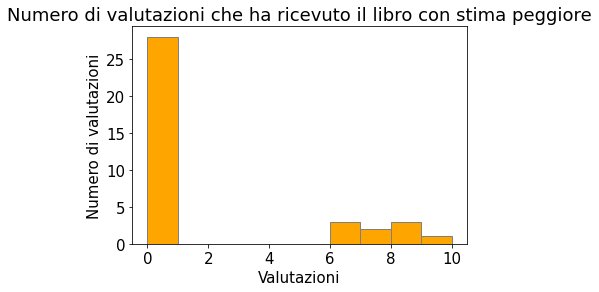

In [ ]:
figura, grafico= plt.subplots()
grafico.hist(x = df_new.loc[df_new['ISBN'] == last_isbn]['bookRating'], 
             ec = "grey",
             fc = "orange" )
plt.xlabel('Valutazioni')
plt.ylabel('Numero di valutazioni')
plt.title('Numero di valutazioni che ha ricevuto il libro con stima peggiore')
plt.show()

# Collaborative Filtering
- I metodi di _collaborative filtering_ forniscono suggerimenti sulla base delle **associazioni** esistenti tra utenti e oggetti
  - in genere vengono usati i **voti** dati dagli utenti agli oggetti
  - non vengono usate informazioni specifiche su singoli utenti (es. età) e oggetti (es. genere)


Uno step fondamentale in un sistema di reccomendation basato sul collaborative filtering è la creazione di una matrice utente-prodotto a partire dalla tabella new_ratings.
La matrice sarà sparsa perchè non tutti gli utenti hanno votato ogni libro.

In [ ]:
ratings_matrix = explicit_ratings.pivot(index='userId', columns='ISBN').bookRating
userId = ratings_matrix.index
ISBN = ratings_matrix.columns

print(ratings_matrix.shape)
ratings_matrix.head()

(449, 66574)


ISBN,0000913154,0001046438,000104687X,0001047213,0001047973,000104799X,0001048082,0001053736,0001053744,0001055607,...,B000092Q0A,B00009EF82,B00009NDAN,B0000DYXID,B0000T6KHI,B0000VZEJQ,B0000X8HIE,B00013AX9E,B0001I1KOG,B000234N3A
userId,,,,,,,,,,,,,,,,,,,,,
2033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Collaborative Filtering basato sugli utenti

Vogliamo prevedere la valutazione che l'utente 7346 darà all'item 0001056107. 
Nella CF basata sugli utenti, troveremo, come prima cosa, gli utenti che sono più simili all'utente 7346. 
Le tecniche comunemente utilizzate sono la similità coseno, di Pearson, Euclidean ecc. Useremo in questa sede la similità coseno e la correlazione di Pearson.

**Similarità coseno**

- La _similarità coseno_ è in generale una misura della similarità tra due vettori
  - è il coseno dell'angolo formato tra i due vettori
  - tiene conto del loro orientamento, non della lunghezza
  - è pari al prodotto scalare dei vettori suddiviso per il prodotto delle loro norme euclidee
  - è compresa tra 0 e 1 per vettori con valori non negativi
$$ \text{sim}(\mathbf{a},\mathbf{b}) = \frac{\sum_{i=1}^n a_i\cdot b_i}{\sqrt{\sum_{i=1}^n a_i^2}\cdot\sqrt{\sum_{i=1}^n b_i^2}} $$


**Correlazione di Pearson**
- Nel modello user-based è possibile utilizzare altre misure di similarità diverse dal coseno
- Una scelta comune è la _correlazione di Pearson_
  - in pratica consiste nella similarità coseno misurata non sui voti ma sul loro scarto rispetto alla media
  - questo bilancia le tendenze di voto diverse degli utenti, equiparando ad es. le 3 stelle di un utente alle 2 di uno più "severo"
$$ {r} = \frac{\sum_{i=1}^n ({x_i}-\bar{x}) \cdot ({y_i}-\bar{y})}{\sqrt{\sum_{i=1}^n ({x_i}-\bar{x})^2}\cdot\sqrt{\sum_{i=1}^n({y_i}-\bar{y})^2}} $$

La funzione findKSimilarUsers prende in input l'Id utente e la matrice di valutazione e restituisce similarità e indici di K utenti simili. 

In [ ]:
import sklearn as skl
import sklearn.neighbors as nbs

In [ ]:
def findKSimilarUsers(user_id, ratings, metric, k = k):
  similarities = []
  indices = []
  model = nbs.NearestNeighbors(metric = metric, algorithm = 'brute')
  model.fit(ratings.to_numpy())
  loc = ratings.index.get_loc(user_id)
  distances, indices = model.kneighbors(ratings.iloc[loc, :].values.reshape(1, -1), n_neighbors = k+1)
  similarities = 1-distances.flatten()
  print ('I {0} utenti più simili all\'utente {1} sono:\n'.format(k,user_id))
  for i in range(0, len(indices.flatten())):
      if indices.flatten()[i]+1 == user_id:
          continue;
      else:
          print('{0}: Utente {1}, con una similarità di {2}'.format(i, indices.flatten()[i]+1, similarities.flatten()[i]))
          
  return similarities,indices

In [ ]:
ratings_matrix.replace([np.inf, -np.inf], np.nan, inplace=True)
ratings_matrix.fillna(0, inplace=True)

**Similarità coseno**

In [ ]:
findKSimilarUsers(7346, ratings_matrix, 'cosine')

I 4 utenti più simili all'utente 7346 sono:

0: Utente 12, con una similarità di 1.0
1: Utente 424, con una similarità di 0.06456544237496042
2: Utente 155, con una similarità di 0.057075683795396404
3: Utente 10, con una similarità di 0.05440117676891487
4: Utente 110, con una similarità di 0.05426173260146627


(array([1.        , 0.06456544, 0.05707568, 0.05440118, 0.05426173]),
 array([[ 11, 423, 154,   9, 109]]))

**Similarità di Pearson**

In [ ]:
findKSimilarUsers(7346, ratings_matrix, 'correlation')

I 4 utenti più simili all'utente 7346 sono:

0: Utente 12, con una similarità di 1.0
1: Utente 424, con una similarità di 0.061168146408081214
2: Utente 110, con una similarità di 0.0517274009503228
3: Utente 155, con una similarità di 0.05109795250083049
4: Utente 10, con una similarità di 0.05069836659933058


(array([1.        , 0.06116815, 0.0517274 , 0.05109795, 0.05069837]),
 array([[ 11, 423, 109, 154,   9]]))

La funzione predict_userbased prevede la valutazione che l'utente 7346 assegnerà all'elemento 0001056107, utilizzando l'approccio CF basato sull'utente. 
Le previsioni vengono calcolate come media ponderata delle deviazioni dalla media del vicino, sommata alla media delle valutazioni media dell'utente. 
Le deviazioni vengono utilizzate per aggiustare eventuali errori che si verificano, per esmepio, quando gli utenti tendono a dare valutazioni sempre alte o sempre basse a tutti i prodotti.

In [ ]:
def predict_userbased(user_id, item_id, ratings, metric, k=k):
    prediction=0
    user_loc = ratings.index.get_loc(user_id)
    item_loc = ratings.columns.get_loc(item_id)
    similarities, indices=findKSimilarUsers(user_id, ratings, metric) # utenti simili in base alla similarità coseno
    mean_rating = ratings.iloc[user_loc,:].mean() 
    sum_wt = np.sum(similarities)-1
    product=1
    wtd_sum = 0 
    
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i] == user_id:
            continue;
        else: 
            ratings_diff = ratings.iloc[indices.flatten()[i],item_loc]-np.mean(ratings.iloc[indices.flatten()[i],:])
            product = ratings_diff * (similarities[i])
            wtd_sum = wtd_sum + product
    
    prediction = int(round(mean_rating + (wtd_sum/sum_wt)))
    print("Il punteggio predetto per l'utente {0} -> item {1}: {2}".format(user_id, item_id, prediction))
    return prediction

In [ ]:
predict_userbased(7346, '0001056107', ratings_matrix, 'cosine')

I 4 utenti più simili all'utente 7346 sono:

0: Utente 12, con una similarità di 1.0
1: Utente 424, con una similarità di 0.06456544237496042
2: Utente 155, con una similarità di 0.057075683795396404
3: Utente 10, con una similarità di 0.05440117676891487
4: Utente 110, con una similarità di 0.05426173260146627
Il punteggio predetto per l'utente 7346 -> item 0001056107: 2


2

In [ ]:
predict_userbased(7346, '0001056107', ratings_matrix, 'correlation')

I 4 utenti più simili all'utente 7346 sono:

0: Utente 12, con una similarità di 1.0
1: Utente 424, con una similarità di 0.061168146408081214
2: Utente 110, con una similarità di 0.0517274009503228
3: Utente 155, con una similarità di 0.05109795250083049
4: Utente 10, con una similarità di 0.05069836659933058
Il punteggio predetto per l'utente 7346 -> item 0001056107: 2


2

## Collaborative Filtering basato sui prodotti

In questo approccio, le somiglianze tra coppie di elementi vengono calcolate utilizzando la metrica di similarità coseno e con la correlazione di Pearson. 

La valutazione dell'elemento i per l'utente considerato u può essere prevista calcolando una media ponderata semplice come:

$$ {p}_{ui} = \frac{\sum\limits_{j \in K} \text{sim}(i, j) \cdot r_{uj}}{\sum\limits_{j \in K} \text{sim}(i, j)} $$

dove K è l'intorno degli elementi simili valutati dall'utente u, 
e sim(i,j) è la similarità tra gli elementi i e j.


Andiamo ora ad implementare funzioni simili per un CF non più basato sugli utenti, ma sui prodotti. 

Il metodo findKSimilarItems individua k libri simili e prevede le valutazioni degli utenti per ognuno di essi. 

In [ ]:
def findKSimilarItems(item_id, ratings, metric, k = k):
  similarities = []
  indices = []
  ratings = ratings.T
  loc = ratings.index.get_loc(item_id)
  model = nbs.NearestNeighbors(metric = metric, algorithm = 'brute')
  model.fit(ratings.to_numpy())
  distances, indices = model.kneighbors(ratings.iloc[loc, :].values.reshape(1, -1), n_neighbors = k+1)
  similarities = 1-distances.flatten()
  print ('I {0} libri più simili al libro {1} sono:\n'.format(k, item_id))
  for i in range(1, len(indices.flatten())):
      if indices.flatten()[i]+1 == item_id:
          continue;
      else:
          print('{0}: Libro {1}, con una similarità di {2}'.format(i, indices.flatten()[i]+1, similarities.flatten()[i]))
          
  return similarities,indices

In [ ]:
findKSimilarItems('000104687X', ratings_matrix, 'cosine')

I 4 libri più simili al libro 000104687X sono:

1: Libro 61510, con una similarità di 1.0
2: Libro 38455, con una similarità di 1.0
3: Libro 4121, con una similarità di 1.0
4: Libro 788, con una similarità di 1.0


(array([1., 1., 1., 1., 1.]), array([[61510, 61509, 38454,  4120,   787]]))

In [ ]:
findKSimilarItems('000104687X', ratings_matrix, 'correlation')

I 4 libri più simili al libro 000104687X sono:

1: Libro 52431, con una similarità di 1.0
2: Libro 18973, con una similarità di 1.0
3: Libro 62335, con una similarità di 1.0
4: Libro 12788, con una similarità di 1.0


(array([1., 1., 1., 1., 1.]), array([[53201, 52430, 18972, 62334, 12787]]))

La funzione predict_itemBased, invece, può essere utilizzata per consigliare libri sempre secondo un approccio basato sui prodotti.
Le recommendation vengono fornite se la valutazione prevista per un libro è maggiore o uguale a 6 e i libri non sono già stati valutati.

In [ ]:
def predict_itembased(user_id, item_id, ratings, metric, k = k):
  prediction = wtd_sum = 0
  user_loc = ratings.index.get_loc(user_id)
  item_loc = ratings.columns.get_loc(item_id)
  similarities, indices = findKSimilarItems(item_id, ratings, metric)
  sum_wt = np.sum(similarities)-1
  product = 1
  for i in range(0, len(indices.flatten())):
    if indices.flatten()[i] == item_loc:
      continue;
    else :
      product = ratings.iloc[user_loc, indices.flatten()[i]]*(similarities[i])
  prediction = int(round(wtd_sum/sum_wt))
  if prediction <= 0:
    prediction = 1
  elif prediction > 10 :
    preditcion = 10
  print('Il punteggio predetto per l\'utente {0} -> item {1}: {2}'.format(user_id, item_id, prediction))
  return prediction

In [ ]:
prediction = predict_itembased(4385, '0001056107', ratings_matrix, 'cosine')

I 4 libri più simili al libro 0001056107 sono:

1: Libro 61361, con una similarità di 0.9922778767136676
2: Libro 47740, con una similarità di 0.8781140799175227
3: Libro 2054, con una similarità di 0.7358236637186912
4: Libro 33936, con una similarità di 0.7071067811865475
Il punteggio predetto per l'utente 4385 -> item 0001056107: 1


In [ ]:
prediction = predict_itembased(4385, '0001056107', ratings_matrix, 'correlation')

I 4 libri più simili al libro 0001056107 sono:

1: Libro 61361, con una similarità di 0.9922437267686637
2: Libro 47740, con una similarità di 0.8775399987138389
3: Libro 2054, con una similarità di 0.7344655967827276
4: Libro 62788, con una similarità di 0.7063171586273639
Il punteggio predetto per l'utente 4385 -> item 0001056107: 1


In [ ]:
import re
import ipywidgets as widgets
import IPython.display as ipd
import contextlib
import sys

@contextlib.contextmanager
def suppress_stdout(suppress=True):
    std_ref = sys.stdout
    if suppress:
        sys.stdout = open('/dev/null', 'w')
        yield
    sys.stdout = std_ref

In base all'approccio e alla metrica di similarità selezionati, la funzione recommendItem prevede la valutazione per l'utente e il libro specificati e suggerisce anche se il libro potrebbe essere consigliato all'utente. 

Se l'elemento non è già valutato dall'utente e se la valutazione prevista è maggiore di 6, il libro viene consigliato all'utente. Se la valutazione è inferiore a 6, il libro non è consigliato all'utente.

In [ ]:
def recommendItem(user_id, ratings):
    if (user_id not in ratings.index.values) or type(user_id) is not int:
      print("userId deve essere un integer valido tra questi: {} ".format(re.sub('[\[\]]', '', np.array_str(ratings_matrix))))
    else :
      ids = ['Correlazione item-based', 'Similarità coseno item-based', 'Correlazione user-based', 'Similarità coseno user-based']
      select = widgets.Dropdown(options=ids, value=None, description='Seleziona approccio', width='1000px')
      def on_change(change):
        ipd.clear_output(wait = True)
        prediction = []
        if change['type'] == 'change' and change['name'] == 'value':
          if (select.value == 'Correlazione item-based') | (select.value == 'Correlazione user-based') :
            metric = 'correlation'
          else :
            metric = 'cosine'
          with suppress_stdout():
            if (select.value == 'Correlazione item-based') | (select.value == 'Similarità coseno item-based'):
              for i in range(ratings.shape[1]):
                if(ratings[str(ratings.columns[i])][user_id] != 0): # non è stato ancora recensito
                 prediction.append(predict_itembased(user_id, str(ratings.columns[i]), ratings, metric))
                 print('da fare')
                else :
                  prediction.append(-1)
            else :
              for i in range(ratings.shape[1]):
                if(ratings[str(ratings.columns[i])][user_id] != 0): # non è stato ancora recensito
                 prediction.append(predict_userbased(user_id, str(ratings.columns[i]), ratings, metric))
                else :
                  prediction.append(-1)
          prediction = pd.Series(prediction)
          prediction = prediction.sort_values(ascending=False)
          recommended = prediction[:10]
          print("secondo l'approccio {0}, i seguenti libri sono consigliati...".format(select.value))
          for i in range(len(recommended)):
            print("{0}. {1}".format(i+1, books.bookTitle[recommended.index[i]]))
      select.observe(on_change)
      display(select)

In [ ]:
recommendItem(4385, ratings_matrix)

secondo l'approccio Correlazione item-based, i seguenti libri sono consigliati...
1. The Red Badge of Courage
2. Mi mamÃ¡ me ama (Nueva narrativa hispÃ¡nica)
3. The Lathe of Heaven
4. Hologram of Liberty: The Constitution's Shocking Alliance With Big Government
5. An American Requiem : God, My Father, and the War That Came Between Us
6. Grimm's Tales for Young and Old
7. One Thousand Paper Cranes: The Story of Sadako and the Children's Peace Statue
8. Macaws of Death
9. The Legend
10. Fear Street. Teufelskreis. Es gibt kein Entkommen... ( Ab 12 J.).


In [ ]:
recommendItem(4385, ratings_matrix)

secondo l'approccio Similarità coseno item-based, i seguenti libri sono consigliati...
1. The Red Badge of Courage
2. Mi mamÃ¡ me ama (Nueva narrativa hispÃ¡nica)
3. The Lathe of Heaven
4. Hologram of Liberty: The Constitution's Shocking Alliance With Big Government
5. An American Requiem : God, My Father, and the War That Came Between Us
6. Grimm's Tales for Young and Old
7. One Thousand Paper Cranes: The Story of Sadako and the Children's Peace Statue
8. Macaws of Death
9. The Legend
10. Fear Street. Teufelskreis. Es gibt kein Entkommen... ( Ab 12 J.).


In [ ]:
recommendItem(4385, ratings_matrix)

secondo l'approccio Correlazione user-based, i seguenti libri sono consigliati...
1. The Gift
2. A Close Run Thing : A Novel of Wellington's Army of 1815
3. The Romantic: A Novel
4. And Never Let Her Go : Thomas Capano: The Deadly Seducer
5. The Titanic Conspiracy: Cover-Ups and Mysteries of the World's Most Famous Sea Disaster
6. The Trouble With Valentines
7. Roger Caras' Treasury of Great Cat Stories
8. Under the Volcano
9. Chop Wood, Carry Water: A Guide to Finding Spiritual Fulfillment in Everyday Life
10. Outerbridge Reach


In [ ]:
recommendItem(4385, ratings_matrix)

secondo l'approccio Similarità coseno user-based, i seguenti libri sono consigliati...
1. The Gift
2. A Close Run Thing : A Novel of Wellington's Army of 1815
3. El perfume
4. The Romantic: A Novel
5. And Never Let Her Go : Thomas Capano: The Deadly Seducer
6. The Titanic Conspiracy: Cover-Ups and Mysteries of the World's Most Famous Sea Disaster
7. The Trouble With Valentines
8. Roger Caras' Treasury of Great Cat Stories
9. Under the Volcano
10. Chop Wood, Carry Water: A Guide to Finding Spiritual Fulfillment in Everyday Life
